# Animating Data Science
*[Kantaro's Side Job](https://www.netflix.com/title/80175348 "ONLY THE BEST LIVE ACTION")*

#### By Christine Jean and Yvonne Luk

## Introduction
Long before The Internet, there were masses of uncoded information. Now, there's still plenty of uncoded information out IRL and online, but there's also some carefully coded datasets that we can utilize to make connections that we would have never imagined with we were just qualitatively evaluating data.

> <span style="color:purple"> <i> "The world is not beautiful, and that is why it is beautiful." </i> 
<br>\- Kino's Journey</span>

If you are looking for some hardcore data scraping, this is not the tutorial for you; the dataset provided has fairly 'nice' and not noisy data. Instead, we will show you how to use and process anime and user rating information of anime to visualize, classify, and try to make recommendations by using machine learning. This will also include some commentary on data science on a field to a bit about Python as a language.

As with other forms of media, there is such a wide variety of anime to choose from, and without the time and patience to watch everything coming out each season or previous seasons, people turn to ratings, reviews, and recommendations to decide what to watch.<br>

The <a href="https://www.kaggle.com/CooperUnion/anime-recommendations-database/">dataset</a> we will be using contains information on animes and user ratings from <a href="https://myanimelist.net/">MyAnimeList.net</a> (MAL), which is a site that allows users to keep a list of animes they're watching or have watched, as well as rate them.

## Before We Start
Below are the libraries needed to do everything in this tutorial. You will also need Python 3.<br>

For documentation on each library, refer to <b>[Resources](#Resources)</b>.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

## I. Data Collection

First, we download the data from https://www.kaggle.com/CooperUnion/anime-recommendations-database/. Our data consists of two comma-separated files: <b>anime.csv</b> and <b>rating.csv</b>. We will be using both files eventually, but we will first be focusing on loading and tidying the data from the <b>anime.csv</b> file. <br><br>
We read the csv file into a Pandas <b>DataFrame</b> called `animetable`. This is a two dimensional data structure with rows and columns (essentially a table). We then check the dimensions and preview the first few rows of the DataFrame to see what our data looks like and to ensure it was read correctly from the file. 

<b>General Tips: </b><br>
* use `df.shape` to get the DataFrame's dimensions
* use `df.head()` to preview the first 5 elements of the DataFrame
* use the `df.sampling(17)` function to get 17 randomly selected rows of the Dataframe

In [3]:
animetable = pd.read_csv('anime.csv')

print(animetable.shape)
animetable.head()

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


By looking at the DataFrame's <b>shape</b>, we can see that there are 12,294 animes in this dataset, and we have 7 attributes for each anime: <b>id</b>, <b>name</b>, <b>genre</b>, <b>type</b>, <b>episodes</b>, <b>rating</b>, and <b>members</b>. For those unfamiliar with MyAnimeList, we have detailed what is in each column below. For those who are familiar, skip to <b>[Data Tidying](#Data-Tidying)</b>. <br>

<b><u>Attributes: </u></b>
- <b>anime_id</b>, <b>name</b>, <b>genre</b>, <b>episodes</b>: these should be pretty self explanatory - the unique ID associated with the anime given by MyAnimeList, the name of the anime, the genre(s) that the anime is in, and the number of episodes - the anime has 1 episode if it's a movie
- <b>type</b>: TV, Movie, <a href="https://www.animenewsnetwork.com/encyclopedia/lexicon.php?id=35">Original Video Animation (OVA)</a>, <a href="https://www.animenewsnetwork.com/encyclopedia/lexicon.php?id=37">Original Net Animation (ONA)</a>, Special, or Music<br>    alternatively, check out <a href="http://www.japanesewithanime.com/2017/03/ova-ona-meaning.html">this</a> and <a href="https://aminoapps.com/c/anime/page/blog/defining-ova-ona-special-episodes-and-movies/bEto_u8PomgzmRaW7MLjQxz5LoZ6VP">this</a> for what is/the difference between OVA and ONA
- <b>rating</b>: the average rating given by those who have rated the anime, on a scale from 1 to 10
- <b>members</b>: the number of users who have added the anime to their anime list - they might or might not have rated or watched it

## II. Data Tidying

A good place to start with cleaning up our data is to check for <b>null values</b> and figure out how to deal with them. It's not ideal to leave null values in because it's not clear what a null value means compared to other values when doing any kind of analysis or visualization. Consider this: maybe a null anime name means that the mechanism used to preprocess this data was not able to read the name or the next hot anime is actually called 'Null.' Ok, granted the latter is a fairly ridiculous example, but it would be within the realm of possibility.

Click <a href="http://www.residentmar.io/2016/06/12/null-and-missing-data-python.html">here</a> for another tutorial related to processing null values.

First, we see where the null values are by counting the number of nulls we have in each attribute.

In [4]:
animetable.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

We notice that <b>rating</b> has the most null values, so we use `head()` to look at some of the animes that lack ratings to see if we can figure out why they might be null and if we should remove or keep them (and if we do keep, how to deal with it).

In [5]:
print ("Anime with Null Ratings: {}".format(animetable[animetable.rating.isnull()].shape[0]))

# storing this table for later ML classification
no_rating = animetable[animetable.rating.isnull()]

animetable[animetable.rating.isnull()].head()

Anime with Null Ratings: 230


,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999


After a general glance through the list, everything without a rating hadn't aired when this dataset was created. Because we will later use the ratings for ML analysis, we are throwing out these rows, and saying that we are only analyzing anime from pre-2017. Ok, these don't have the years on them, but we are weebs so we can tell. Trust us.<br><br>
We use `dropna()` to remove these rows, and check for more null values.

In [6]:
animetable = animetable.dropna(subset=['rating'])
animetable.isnull().sum()

anime_id     0
name         0
genre       47
type         0
episodes     0
rating       0
members      0
dtype: int64

We notice that some of the null values in other attributes were for the same animes as the ones without ratings. However, there are still some animes with null values, in <b>genre</b>, so we look at those.

In [7]:
print ("Anime without genre: {}".format(animetable[animetable.genre.isnull()].shape[0]))
animetable[animetable.genre.isnull()].head()

Anime without genre: 47


,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607


We decide to throw out the instances without genres as well. There are only a few, with generally low interest, and we still have a lot of data to consider (12,000+ other animes).

In [8]:
animetable = animetable.dropna(subset=['genre'])
no_rating = no_rating.dropna(subset=['genre'])

We also notice that some animes have an <b>'unknown' number of episodes</b>. We check which ones do and how many there are.

In [9]:
print("Anime with 'Unknown' episodes: {}".format(animetable[animetable.episodes == 'Unknown'].shape[0]))
animetable[animetable.episodes == 'Unknown'].head()

Anime with 'Unknown' episodes: 187


,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400


After glancing through this list, we treat all unknown episode values by replacing them with 1. In this case, we want to keep the corresponding data, but also be able to treat the episodes as numerical values.

Now, you might think, is it ok to just replace something with an arbitrary value? 1 is not completely arbitrary; to be on this list, an anime must have at least one entity. For the sake of keeping some of the popular animes with unknown episodes, we give it such value. Also, these animes are probably the ones that were still airing at that point. If you've ever kept up with a current season and tracked your progress on MAL, you'll see that the number of episodes have not been listed. However, later as we will see in ML, the number of episodes gets omitted for classification because of the 'arbitrary-ness' of assigning 'Unknown' to 1, and we do not use the number of episodes in our data visualization.

As a general note, in data science, there's not always a right or wrong decision, as long as you've justified why you've chosen an approach. [Here is a short read on the difficulties of counting](http://daynebatten.com/2016/06/counting-hard-data-science/); though not completely the same statistical use, we are trying to figure out which animes to count or not count in our analysis.

In [10]:
animetable.episodes = animetable.episodes.replace(['Unknown'], 1)

After dealing with unknown and null values, we convert our <b>quantitative values</b> in our DataFrame from <b>strings</b> to <b>numbers</b> so we can do some math!

In [11]:
animetable.episodes = animetable.episodes.astype(int)
animetable.rating = animetable.rating.astype(float)
animetable.members = animetable.members.astype(int)
animetable.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Having dealt with the <b>anime.csv</b> file, we now turn to the <b>rating.csv</b> file, reading the file in and checking it. 

In [12]:
ratingtable = pd.read_csv('rating.csv')
print("Number of ratings: {}".format(ratingtable.shape[0]))
print("Number of raters: {}".format(len(ratingtable.user_id.unique())))
ratingtable.head()

Number of ratings: 7813737
Number of raters: 73515


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
ratingtable.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

The DataFrame for ratings seems fine. This DataFrame contains the ratings given by 73,516 users to animes on their list - their rating is given on a scale of 1 to 10, with -1 representing a rating not given.


## III. Data Visualization

> <span style="color:purple"> <i> "Even if your life is full of tears and sorrow, the world is still a beautiful place. Open your eyes and see it for yourself." </i> 
<br>\- Clannad</span>

Data visualization is also a beautiful thing because it takes typically dimensional data and gives it some meaning beyond numbers or words in a table.

Here are some of the things we want to visually show:
- What is the most popular genre of anime?
- What genres have many ratings?
- Do animes with more genres do better in terms of rating?
- Do animes with more genres do better in terms of popularity (measured by community size)?
- Do people give more positive or negative ratings?

First, we want to see <b>how many animes are in each genre</b>. As is, our <b>genre</b> column is a string representing all the genres the anime is in. If we want to do visualization and analysis with genres later, we need to tidy it. We can do that by making each genre into an attribute, which then has a 1/0 value representing whether the anime has that genre or not. We also create a column called <b>genreCount</b> to count the number of genres each anime has (to be used later).

In [14]:
animetable.genre = animetable.genre.apply(lambda x: x.split(', '))
animetable['genreCount'] = animetable.genre.apply(lambda x: len(x))
no_rating.genre = no_rating.genre.apply(lambda x: x.split(', '))
no_rating['genreCount'] = no_rating.genre.apply(lambda x: len(x))

In [15]:
# create unique list of all possible genres
genre_list = list(itertools.chain.from_iterable(animetable.genre.values.flatten()))
genre = np.unique(genre_list)
print("There are {} genres".format(len(genre)))
genre

There are 43 genres


array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen',
       'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life',
       'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller',
       'Vampire', 'Yaoi', 'Yuri'], 
      dtype='<U13')

In [16]:
# create attributes for each genre with 1/0 values representing whether the anime is a certain genre
for category in genre: # loops through each category type
    # the lambda function basically figures out if a genre is in the list and if it is, assigns a 1, otherwise a 0
    no_rating[category] = no_rating.genre.apply(lambda x: int(category in x))
    animetable[category] = animetable.genre.apply(lambda x: int(category in x))

animetable = animetable.drop(['genre'], axis = 1)
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, let's make a DataFrame with anime counts for each genre to visualize how many animes are a genre!

In [17]:
genre_count = []

for category in genre: 
    genre_count.append(genre_list.count(category))
    
dict = {'genre': genre, 'count':genre_count}
genre_df = pd.DataFrame(dict) 

In [18]:
genre_df.sort_values(by = "count", ascending = False)

,count,genre
3,4575,Comedy
0,2768,Action
1,2316,Adventure
8,2242,Fantasy
28,2036,Sci-Fi
6,1977,Drama
32,1684,Shounen
15,1598,Kids
25,1437,Romance
34,1204,Slice of Life


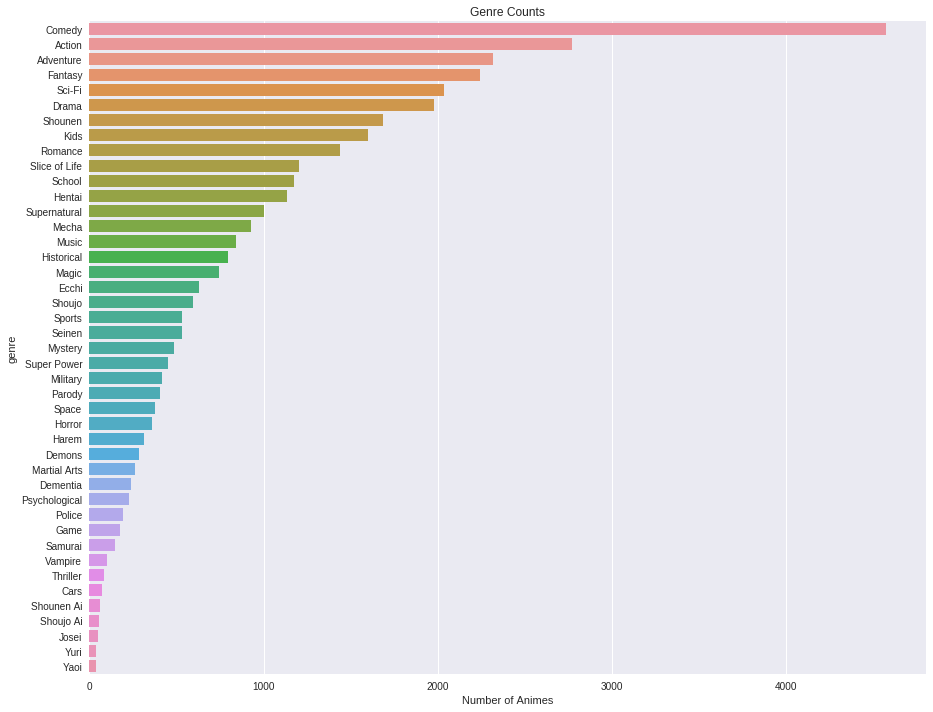

In [19]:
# let's visualize the table above!
fig, ax = plt.subplots(figsize=(15, 12))
result = genre_df.groupby(['genre'])['count'].aggregate(np.median).reset_index().sort_values('count', ascending = False)
sns.barplot(x='count', y='genre', data=genre_df, order = result['genre'], ax = ax).set_title("Genre Counts")
ax.set(xlabel="Number of Animes")
plt.show()

From this, we can see <b>Comedy</b> is the genre with the most animes in it by a large margin, followed by <b>Action</b>, <b>Adventure</b>, and <b>Fantasy</b>, which are much closer together in count. It is hard to speak to the accuracy of tagging of anime without taking a deep dive into looking at some of the individual entities on this list. However, it should not be a surprise that a genre like **Comedy** has so many instances, as **Comedy** tends to go with many other genres. On the other hand, there probably aren't many **Sci-fi**, **Historical** animes out there (what, would that be like Cowboys and Aliens, but better? Steampunk?) or anything that is both **Shoujo** and **Shounen**.

<img src="https://pm1.narvii.com/5917/b261e12c617a96a9601968729fbd448996234c3a_hq.jpg" width="500"/>
<center>**VS**</center>
<img src="https://images-na.ssl-images-amazon.com/images/I/61PNEPH8W9L.jpg" width="500"/>

Next, we want to count the <b>number of users</b> from the ratings dataset who have the anime on their list and <b>rated or didn't rate the anime</b>, so for each anime in our anime DataFrame, we count how many users gave that anime a -1 rating (didn't rate) or an actual rating. We do this by creating two new columns, <b>unrated</b> and <b>rated</b> and <b>applying a function</b> to every row in the anime dataframe. <br><br>
Then, we create a DataFrame with the number of ratings given/not given in each genre by summing the <b>unrated</b> and <b>rated</b> for every anime in each genre.

In [20]:
#running this cell will make you cry for 30 minutes
#we have to count unrated and rated, rather than just one and subtracting from the total number of members because the
    #ratings dataset doesn't contain data for all members
#because we are going by each anime in the anime DataFrame, we don't have to check for animes removed from the DataFrame
animetable['unrated'] = animetable.anime_id.apply(lambda x: ratingtable[
    (ratingtable['anime_id'] == x) & (ratingtable['rating']==-1)].shape[0])
animetable['rated'] = animetable.anime_id.apply(lambda x: ratingtable[
    (ratingtable['anime_id'] == x) & (ratingtable['rating']!=-1)].shape[0])
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,unrated,rated
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,0,0,1,0,0,0,0,238,1961
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,0,0,3080,21494
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,0,0,198,1188
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,0,0,1,0,0,0,2132,17151
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,0,0,558,3115


In [21]:
# creating two Pandas Series to keep count
genreRated = pd.Series()
genreUnrated = pd.Series()
for g in genre:
    genreRated[g] = animetable[animetable[g]==1].rated.sum()
    genreUnrated[g] = animetable[animetable[g]==1].unrated.sum()

In [61]:
# combining this information into a DataFrame
genreTotal = genreRated + genreUnrated

#we want our genres displayed in the same order as the Genre Counts graph above (by count) for comparison
ratingGenres = pd.DataFrame({'genre': genre, 'unrated':genreUnrated,'rated':genreRated,'total':genreTotal,'count':genre_count})
ratingGenres.reset_index(drop = True, inplace=True)
ratingGenres = ratingGenres.sort_values(by = "count", ascending = False)
ratingGenres

,count,genre,rated,total,unrated
3,4575,Comedy,3150030,3908785,758755
0,2768,Action,2663843,3263393,599550
1,2316,Adventure,1365199,1695965,330766
8,2242,Fantasy,1629076,2021336,392260
28,2036,Sci-Fi,1319449,1613124,293675
6,1977,Drama,1727683,2101320,373637
32,1684,Shounen,1514011,1882226,368215
15,1598,Kids,100229,133863,33634
25,1437,Romance,2031673,2487902,456229
34,1204,Slice of Life,906012,1098829,192817


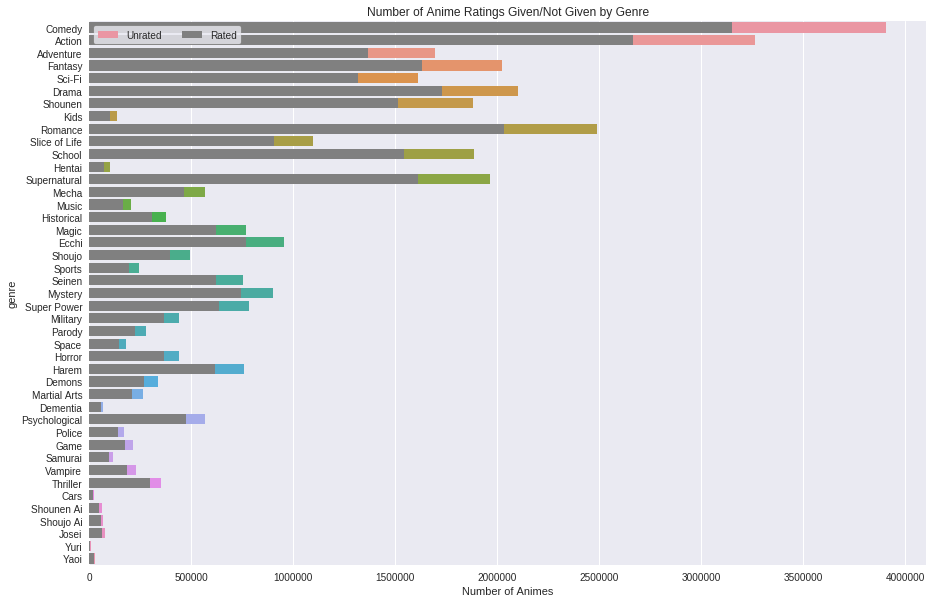

In [62]:
# graphing number of ratings given/not given by genre

f, ax = plt.subplots(figsize=(15,10))
# again, we are using the same order as the Genre Counts graph
result = ratingGenres.groupby(["genre"])['count'].aggregate(np.median).reset_index().sort_values(
    'count', ascending = False)
# using 'Total' to stack unrated and rated - just the length of the colored part is 'Unrated'
sns.barplot(x="total", y="genre", data=ratingGenres, order = result['genre'], label="Unrated") 
sns.barplot(x="rated", y="genre", data=ratingGenres, order = result['genre'], color = 'gray', label="Rated")

ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(ylabel="genre",
       xlabel="Number of Animes",
       title = "Number of Anime Ratings Given/Not Given by Genre")

plt.show()

There are a couple things going on with the above graph: first, we can see that the grey part is significantly longer than the colored part for each genre, so we can tell that there are more ratings given by the members in the dataset than ratings not given. This makes sense because the purpose of the ratings dataset was to provide member's ratings, so it would make sense that the creator would choose users who gave a lot of ratings to be part of the dataset. Second, besides the first two genres, <b>Comedy</b> and <b>Action</b>, the rest of the genres are scrambled in their order. This tells us that the genres that have the most animes in them might not necessarily be the most popular animes, at least based on the number of members from the dataset with the anime of those genres on their list.

Next we want to show the <b>number of members vs ratings given for each anime, grouped by type</b>.

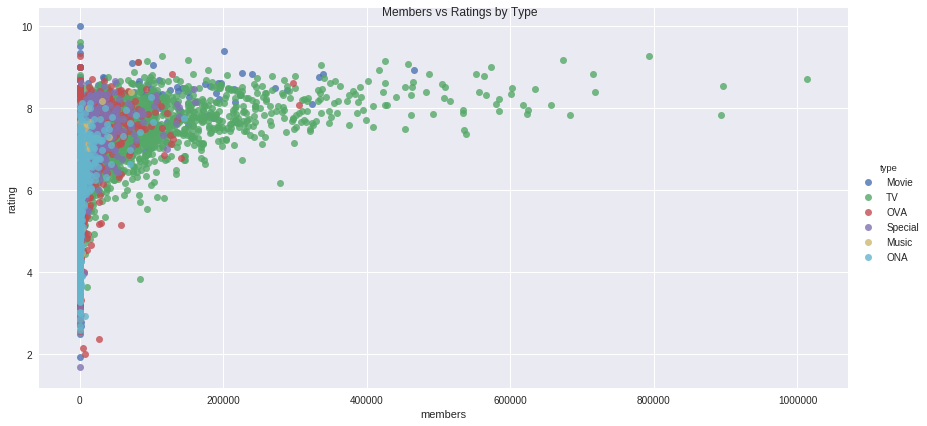

In [56]:
g = sns.lmplot(y = "rating", x = "members", data=animetable, hue="type", size = 6, aspect = 2, fit_reg=False)
g.fig.suptitle("Members vs Ratings by Type")

Generally, we see the same rating shape for each type, where there's a max of members per type at around the 7-8 rating. The main difference is in the amount of members, with <b>TV</b> type having the most. This makes sense because the TV animes have the most content, so tend to have more followers.

We also want to see <b>how many genres animes typically have</b>, so we plot the number of animes vs number of genres that were in an anime's genre list. Keep in mind, these are based upon MAL's genre tagging system, which may be a subjective process. We are just analyzing the information given.

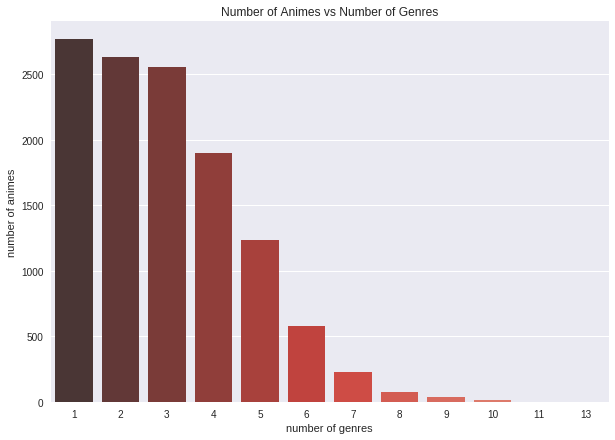

In [45]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x="genreCount", data=animetable, palette="Reds_d", ax = ax)
ax.set(xlabel="number of genres",
       ylabel="number of animes",
       title="Number of Animes vs Number of Genres")

From this, we can see most animes have 1, 2, or 3 genres, with there being fewer and fewer animes as number of genres increases.

Next we want to see <b>what kind of ratings</b> people from the <b>ratings</b> dataset gave. 

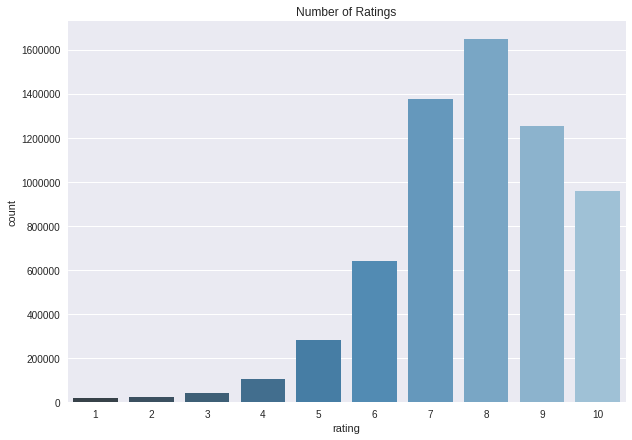

In [46]:
#Do people give more positive or negative ratings?
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='rating', data=ratingtable[ratingtable['rating'] != -1], palette="Blues_d", ax = ax)
ax.set(xlabel="rating",
       ylabel="count",
       title="Number of Ratings")

# Alternatively, to see the counts, uncomment the line of code below
#ratingtable['rating'].value_counts()

It turns out that people generally do give positive ratings! Maybe this could be due to people generally rating for sake of recommending content. I am personally surprised that there's not more ratings of 1, since I've definitely seen anime that I've utterly hated and had such a visceral response to that I had to immediately go to MAL and give it a 1 so no one would have to suffer through what I had just gone through.

## IV. Machine Learning
Machine learning allows us to train algorithms to our dataset and use what those algorithms learned to make predictions on a new set of data.

We first want to see if we can try <b>classifying by popularity</b> into whether an anime is popular or not. Classification in machine learning is the sorting of data into groups, which ML can then use to put new data into these groups. To do this, we put animes into a binary group representing popularity. We choose to define popularity by the number of members following the anime. Ratings also factor into popularity, but it is difficult define a function that takes into account ratings and number of members. Also, there may be many low interest, high rated content, which would be considered positive popularity, but how would they be compared to big animes like One Piece?

In [47]:
# let's figure out if we can somehow classify by popularity, based on number of members
animetable['membersRange'] = animetable.members.apply(lambda a: max(0, (int(a) - (int(a) % 50000))))
animetable['membersRangeLog'] = animetable.members.apply(lambda a: int(math.log(a, 10)))
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,unrated,rated,membersRange,membersRangeLog
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,1,0,0,0,0,238,1961,200000,5
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,3080,21494,750000,5
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,198,1188,100000,5
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,1,0,0,0,2132,17151,650000,5
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,558,3115,150000,5


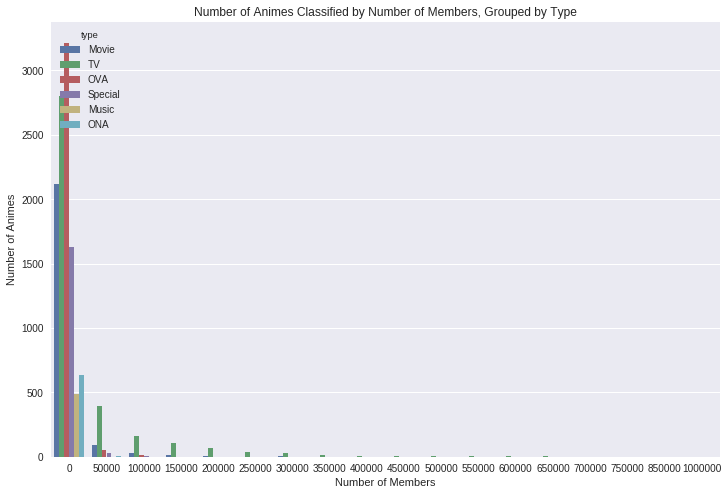

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.countplot(x="membersRange", hue = "type", data=animetable, ax= ax)
ax.set(title="Number of Animes Classified by Number of Members, Grouped by Type",
      xlabel="Number of Members",
      ylabel="Number of Animes")

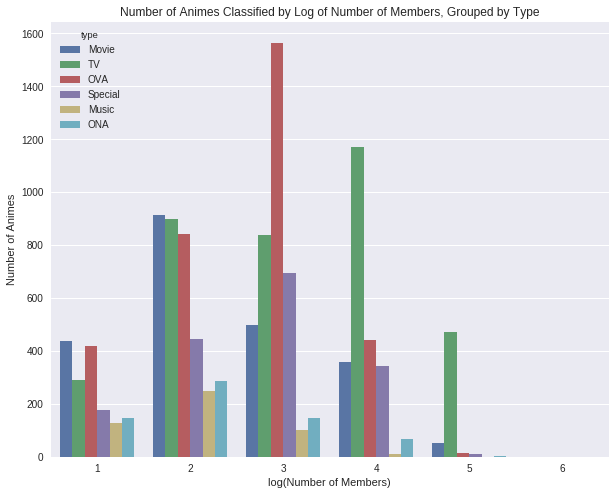

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(x="membersRangeLog", hue = "type", data=animetable, ax = ax)
ax.set(title="Number of Animes Classified by Log of Number of Members, Grouped by Type",
      xlabel="log(Number of Members)",
      ylabel="Number of Animes")

As can be seen, most anime get classified into the 0 - 50,000 range, which is not very helpful as a classifier. We see a huge skew to the left, and values to the right are very small in comparison, so let's use the logarithmic transfermation.

In [51]:
print("Some animes with 1,000 - 9,999 members:")
print(animetable[animetable['membersRangeLog'] == 3].sample(5).name)
print("\nSome animes with 10,000 - 99,999 members:")
print(animetable[animetable['membersRangeLog'] == 4].sample(5).name)

Some animes with 1,000 - 9,999 members:
3000      Rockman.EXE Beast+
5254       Natsu e no Tobira
6883                 _Summer
11373    Soreyuke Marin-chan
3828        Haunted Junction
Name: name, dtype: object

Some animes with 10,000 - 99,999 members:
2191    Kimi no Iru Machi: Tasogare Kousaten
3523              Ikkitousen: Dragon Destiny
2979                           Deltora Quest
2160            One Piece 3D: Mugiwara Chase
3304                          Mizu no Kotoba
Name: name, dtype: object


I personally have no idea what most of these animes listed are. Typically, in your results, you probably don't want to include this in your writeup. However, this is to demonstrate that you should be constantly looking at your data and checking that choices make sense. 

We essentially arbitrarily decide that anything with more than 10,000 members will be considered "popular". We thus make a column with 1/0 values in the DataFrame, labeling the anime as being popular(1) or not(0).

In [52]:
animetable['popularClass'] = animetable.membersRangeLog.apply(lambda a: int(a > 3))

In [66]:
animetable.sample(10)

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Supernatural,Thriller,Vampire,Yaoi,Yuri,unrated,rated,membersRange,membersRangeLog,popularClass
8710,16027,Greek Roman Sinhwa: Olympus Guardian,TV,39,6.57,275,3,0,1,0,...,0,0,0,0,0,1,1,0,2,0
9757,28545,Nobunaga-kun no Minna de Yakusoku Hi no Youjin,OVA,1,5.67,51,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4623,7568,Umineko no Naku Koro ni Specials,Special,26,6.68,10913,2,0,0,0,...,0,0,0,0,0,98,186,0,4,1
2199,4879,Mouryou no Hako,TV,13,7.33,36075,4,0,0,0,...,1,1,0,0,0,117,565,0,4,1
11168,32667,Baka na Imouto wo Rikou ni Suru no wa Ore no x...,OVA,4,7.24,3965,1,0,0,0,...,0,0,0,0,0,15,38,0,3,0
1132,8888,Code Geass: Boukoku no Akito 1 - Yokuryuu wa M...,Movie,1,7.66,91105,4,1,0,0,...,0,0,0,0,0,668,2684,50000,4,1
10835,24981,Yowamushi Chinsengumi,Movie,1,5.75,74,2,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5289,23697,Kara no Kyoukai: Manner Movies,Movie,7,6.49,5367,2,1,0,0,...,0,0,0,0,0,53,106,0,3,0
3554,21671,Keroro,TV,23,6.96,3260,3,0,0,0,...,0,0,0,0,0,13,32,0,3,0
12009,4498,Ikenie,OVA,1,5.73,716,1,0,0,0,...,0,0,0,0,0,7,14,0,2,0


Now that we have our dataset classified into popular or not popular, we can put our data through a classification algorithm and see if it will correctly predict if something's popular or not, using <b>genre</b> and <b>type</b> as our features. We considered using episodes as well, as a high number of episodes likely means an anime is popular enough to be renewed for more seasons, but because many of the ongoing, popular animes had an unknown number of episodes in our dataset, we decided against using episodes. <br><br>
The classification algorithm used is <b>K nearest neighbors</b>. In essence, it will classify an anime based upon the classifications of it's k-nearest-neighbors.
![kNN](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/266px-KnnClassification.svg.png)

Via this example from Wikipedia, when k = 3, the green circle with the question mark is currently unclassified. When k = 3, we will look at it's 3 closest neighbors, where we can see it has more red triangle neighbors (2) than blue square neighbors (1); thus the green circle will be classified as a red triangle. When k = 5, we would classify the green circle as a blue square. 'Nearest' can be determined by any measure, but is often done with Euclidean distance.

For better understanding of the algorithm and some other useful Python walkthrough, <a href = "https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/"> Kevin Zakka</a> does a great job explaining how K nearest neighbors works.

### Other concepts to understand:

**Testing versus Training data:** Literally, the training set is used to get the corresponding weights for our function or algorithm. The testing set, which is a completely separate set, is used to try out these learned weights, which leads us to one of the reasons for why we need to do this...

**Overfitting:** when we are able to accurate classify the data we have to such a high probability that it does not generalize well considering other data. If we run our classification algorithm to maximize classification accuracy on the training set but the testing set has low classification accuracy given those learned values, we have probably overfitted. In general, the training to testing set ratio varies, but a good rule of thumb, which we apply, is 80% is training data, 20% is testing data.

In [53]:
format_type = [s for s in list(animetable) if "type_" in s]
animetable_type = pd.get_dummies(animetable, columns = ['type'])
attributes = pd.concat([animetable[genre],animetable[format_type]],axis=1)
classification = np.array(animetable['popularClass']) 	# another way of indexing a pandas df

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(attributes, classification, test_size=0.2, random_state=42)

In [54]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
print (accuracy_score(y_test, pred))

0.803244592346


Notice, we've set k = 3. This is known as a **hyperparameter**. We can also determine what's the 'best' value (in the sense of general highest accuracy, lowest error rate) k-neighbors to consider via **cross validation**. In ML, there is the testing set, the training set, and the validation set.

Via k-fold cross validation (we use 10-fold below), we split the training data into k equal subsets. For each iteration, we run the normal algorithm on k-1 of the subsets, and compare the fitted results to the 1 subset omitted during the iteration. We can do this k times, each time taking out a different subset while fitting; this is known as our validation set. The results are then averaged to get a general score to determine the best hyperparameter value to use. k-fold can especially be used when you might not have much data to work with.

In [59]:
# creating odd list of K for KNN
# this may also take a little bit
myList = list(range(1,20))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [60]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 15


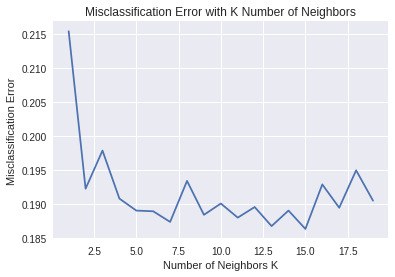

In [61]:
# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error with K Number of Neighbors')
plt.show()

In [62]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
print (accuracy_score(y_test, pred))

0.805740432612


Let's try this on our unrated 2017 anime! Do you think that this is accurate based upon the number of members that the anime had when the dataset was created? Do you think that this is accurate after this anime season (Boku no Hero Academia was classified as popular!)?

In [91]:
format_type = [s for s in list(no_rating) if "type_" in s]
no_rating_type = pd.get_dummies(no_rating, columns = ['type'])
attributes = pd.concat([no_rating[genre],no_rating[format_type]],axis=1)
pred = knn.predict(attributes)
no_rating['classification'] = pred # store the predictions into the dataframe. will be in form of 1/0
no_rating[['name','type','members','classification']]

,name,type,members,classification
8968,Inazma Delivery,TV,32,0
9657,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,TV,129,0
10896,Gintama (2017),TV,13383,1
10897,One Punch Man 2,TV,90706,0
10898,Steins;Gate 0,NaN,60999,0
10899,Shingeki no Kyojin Season 2,TV,170054,1
10900,Code Geass: Fukkatsu no Lelouch,NaN,22748,0
10901,Boku no Hero Academia 2nd Season,TV,46892,1
10902,Kono Subarashii Sekai ni Shukufuku wo! 2,TV,54069,0
10903,Ao no Exorcist: Kyoto Fujouou-hen,TV,45127,1


## IV-PS: Just for Fun

> <span style="color:purple"> <i> "I can see it... I can see the ending!" </i> 
<br>\- The World Only God Knows</span>

Now just for fun, what if we want to get anime recommendations?

We have talked about the KNN classification algorithm, but what if we just want to get the nearest neighbors? Let's try exactly that!

In [83]:
# find all of the animes that contain the search term
def findAnime(name, df):
    list = []
    indices = []
    for index, row in df.iterrows():
        if (name.lower() in row['name'].lower()):
            list.append(row['name'])
            indices.append(row.name)
    return list, indices

# find similar animes based upon the Ball Tree nearest neighbors algorithm
def findSimilar(index, df, attributes, neighbors = 2):
    list = []
    tree = BallTree(attributes, leaf_size=2)              
    dist, ind = tree.query([attributes.iloc[index]], k = neighbors)
    for i in ind.flatten():
        list.append(animetable.iloc[i]['name'])
    return list

In [84]:
animelist, indices = findAnime("Naruto", animetable)
print("Anime similar to ", animelist[0])
findSimilar(indices[0], animetable, attributes, 10)

Anime similar to  Boruto: Naruto the Movie


['Naruto x UT',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto Shippuuden: Sunny Side Battle',
 'Naruto: Shippuuden',
 'Boruto: Naruto the Movie',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Naruto',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Battle Spirits: Ryuuko no Ken']

It would make sense that the recommendations for "Naruto" would be from the same franchise. 

In [85]:
animelist, indices = findAnime("Kimi no Na wa", animetable)
print("Anime similar to ", animelist[0])
findSimilar(indices[0], animetable, attributes, 10)

Anime similar to  Kimi no Na wa.


['Kimi no Na wa.',
 'Wind: A Breath of Heart OVA',
 'Wind: A Breath of Heart (TV)',
 'Angel Beats!: Another Epilogue',
 'Kokoro ga Sakebitagatterunda.',
 '&quot;Bungaku Shoujo&quot; Memoire',
 'True Tears',
 'Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen',
 'Myself; Yourself',
 'Kimikiss Pure Rouge']

Although I don't recognize some of the animes on this list, of the ones I do recognize, they are quite similar to Kimi no Na Wa in being about high schoolers and romance, and as someone who loved Kimi no Na Wa, enjoyed those as well.

## V. Conclusion

> <span style="color:purple"> <i> "It's not ending. Everything's just starting." <i> 
<br>\- Shugo Chara</span>

In this tutorial, we went over how to clean up and manipulate two datasets, make visualizations from the data and draw conclusions from these visualizations, and do basic machine learning with algorithms to classify, make predictions, and make recommendations. <br><br>
Data science allows us to learn about the data and accomplish feats that would not be possible without the aid of computers capable of handling and processing vast sets of data. <br><br>
We hope you use these techniques to further analyze this set of data or another dataset, and learned as much about data science and anime as we did preparing this tutorial for you!

##  VI. Resources

Check out these resources to try out your own anime data science project!

> <span style="color:purple"> <i> "You're gonna carry that weight." <i> 
<br>\- Cowboy Bebop</span>

[Anaconda](https://anaconda.org/anaconda/python)

[Jupyter Notebook](http://jupyter.org/)

[Pandas](https://pandas.pydata.org/)

[Numpy](http://www.numpy.org/)

[Seaborn](https://seaborn.pydata.org/)

[Matplotlib](https://matplotlib.org/)

[Math](https://docs.python.org/2/library/math.html)

[Sklearn](http://scikit-learn.org/stable/)